In [1]:
# !pip install insightface
# !pip install onnxruntime
# !pip install diffusers
# !pip install git+https://github.com/tencent-ailab/IP-Adapter.git
# !pip install einops
# !pip install accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 43.0 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1054322 sha256=a288943d9be92a59bc52f3b21b420baf20e4c607af97511760472c134849a2c2
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.2 MB/s eta 0:00:00
  Cloning https://github.com/

In [14]:
!wget -O ip-adapter-faceid_sd15.bin https://huggingface.co/h94/IP-Adapter-FaceID/resolve/main/ip-adapter-faceid_sd15.bin?download=true

--2023-12-25 20:58:37--  https://huggingface.co/h94/IP-Adapter-FaceID/resolve/main/ip-adapter-faceid_sd15.bin?download=true
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.23, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/36/ca/36ca54ff1895000df817b45a5ae71fccd14170b0843d8adc2ba7944d9ac903e9/201344e22e6f55849cf07ca7a6e53d8c3b001327c66cb9710d69fd5da48a8da7?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27ip-adapter-faceid_sd15.bin%3B+filename%3D%22ip-adapter-faceid_sd15.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1703797117&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwMzc5NzExN319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzM2L2NhLzM2Y2E1NGZmMTg5NTAwMGRmODE3YjQ1YTVhZTcxZmNjZDE0MTcwYjA4NDNkOGFkYzJiYTc

In [2]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


In [3]:
import torch
import cv2
from insightface.app import FaceAnalysis


app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))



download_path: C:\Users\HEHUA/.insightface\models\buffalo_l


100%|██████████| 281857/281857 [00:03<00:00, 84579.70KB/s] 
c:\Users\HEHUA\.conda\envs\control-v11\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\HEHUA/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\HEHUA/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\HEHUA/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\HEHUA/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\HEHUA/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

In [11]:
import torch
from diffusers import StableDiffusionControlNetPipeline, DDIMScheduler, AutoencoderKL, ControlNetModel
from PIL import Image

from ip_adapter.ip_adapter_faceid import IPAdapterFaceID

base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
#base_model_path = "SG161222/Realistic_Vision_V6.0_B1_noVAE"
#runwayml/stable-diffusion-v1-5
#base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
ip_ckpt = "models/ip-adapter-faceid_sd15.bin"
device = "cuda"

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)




ControlNet Depth

In [5]:
# load controlnet
controlnet_model_path = "lllyasviel/control_v11f1p_sd15_depth"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)


Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


c:\Users\HEHUA\.conda\envs\control-v11\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


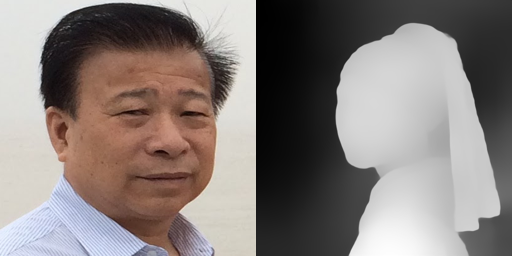

In [7]:
image_path = "assets/images/Qinsong_face1.png"
image = cv2.imread(image_path)
faces = app.get(image)
faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)

orignal_image = Image.open(image_path)
depth_map = Image.open("assets/structure_controls/depth.png")
image_grid([orignal_image.resize((256, 256)), depth_map.resize((256, 256))], 1, 2)

100%|██████████| 30/30 [00:11<00:00,  2.50it/s]


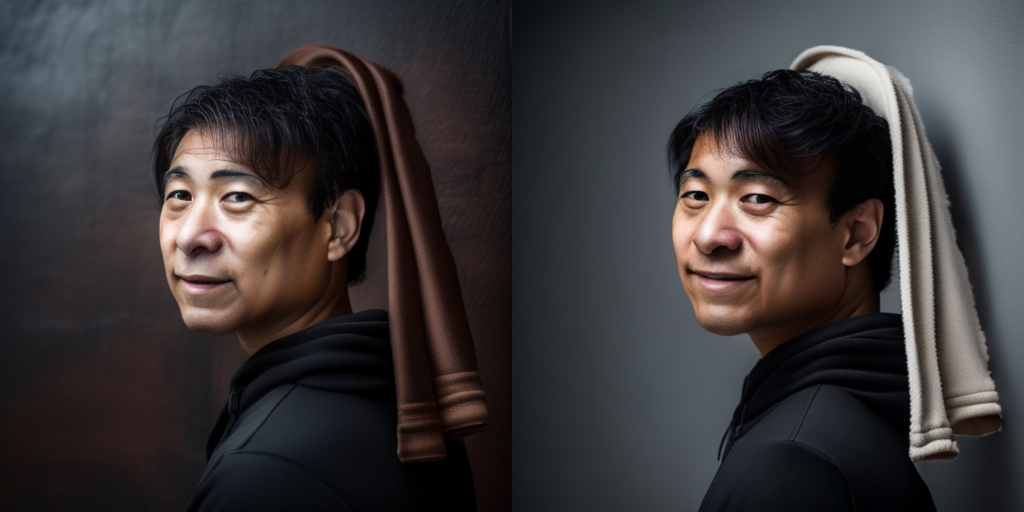

In [13]:

# load ip-adapter
ip_model = IPAdapterFaceID(pipe, ip_ckpt, device)
ip_model.set_scale(0.7)
# # generate image
prompt = "half body photo of a 45 y.o man from China, black hair, 8k uhd, high quality"
negative_prompt = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime), text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck,naked"

# images = ip_model.generate(
#     prompt=prompt, negative_prompt=negative_prompt, faceid_embeds=faceid_embeds, num_samples=2, width=512, height=768, num_inference_steps=30, seed=1022
# )

images = ip_model.generate(prompt=prompt, negative_prompt=negative_prompt, pil_image=image, image=depth_map,faceid_embeds=faceid_embeds, num_samples=2, num_inference_steps=30, seed=42)
grid = image_grid(images, 1, 2)
grid

## ControlNet OpenPose

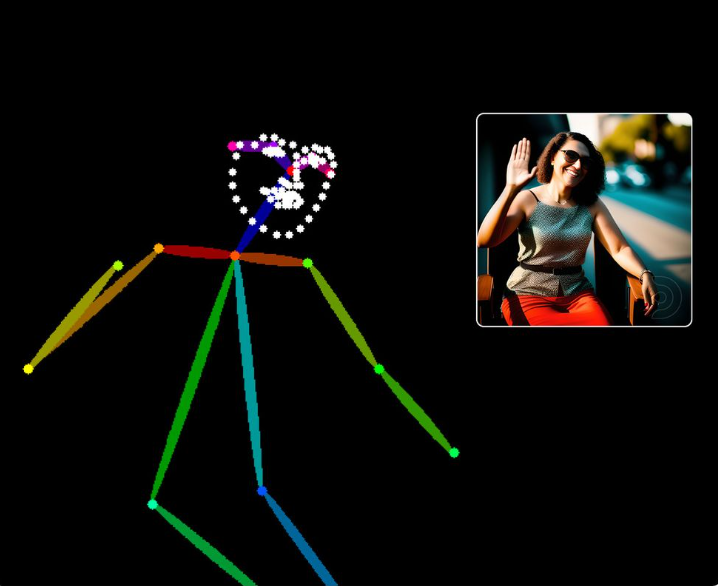

In [14]:
# load SD pipe
del pipe, ip_model
torch.cuda.empty_cache()
# load controlnet
controlnet_model_path = "lllyasviel/control_v11p_sd15_openpose"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


In [36]:
openpose_image = Image.open("assets/images/pose1.png")
openpose_image = openpose_image.resize((256, 384))

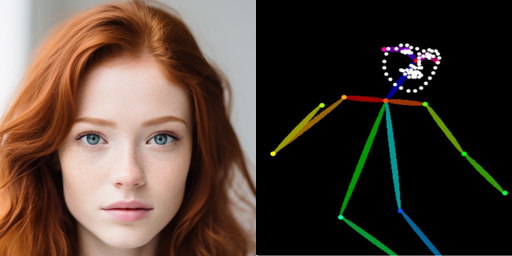

In [38]:
image_path = "assets/images/ai_face2.png"
image = cv2.imread(image_path)
faces = app.get(image)
faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)

openpose_image = Image.open("assets/images/pose1.png")
openpose_image.resize((256, 384))

orignal_image = Image.open(image_path)

image_grid([orignal_image.resize((256, 256)), openpose_image.resize((256, 256))], 1, 2)

100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


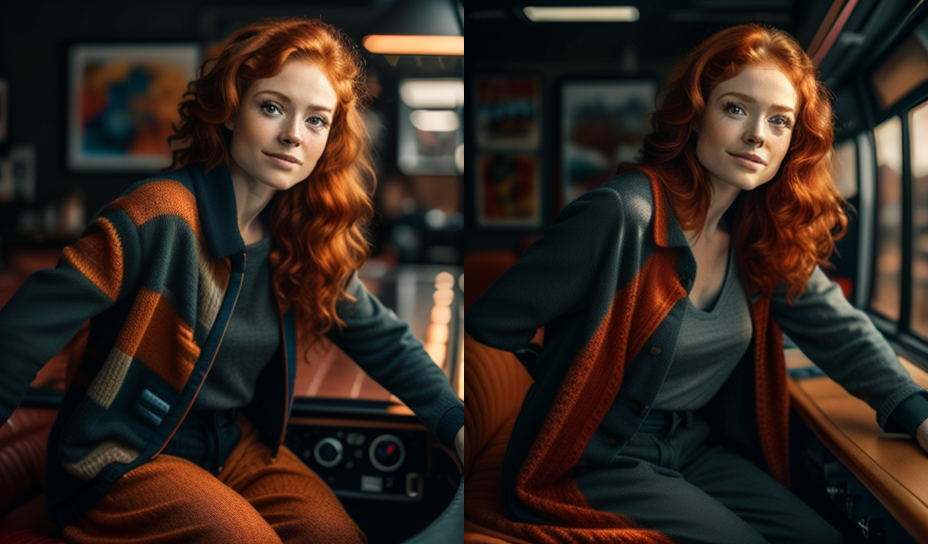

In [40]:

# load ip-adapter
ip_model = IPAdapterFaceID(pipe, ip_ckpt, device)
ip_model.set_scale(0.7)
# # generate image
prompt = "photo of a 35 y.o woman, 8k uhd, high quality"
negative_prompt = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime),naked, broken hand, text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck,naked"

# images = ip_model.generate(
#     prompt=prompt, negative_prompt=negative_prompt, faceid_embeds=faceid_embeds, num_samples=2, width=512, height=768, num_inference_steps=30, seed=1022
# )

images = ip_model.generate(prompt=prompt, negative_prompt=negative_prompt, pil_image=image, image=openpose_image,faceid_embeds=faceid_embeds, num_samples=2, num_inference_steps=30, seed=42)
grid = image_grid(images, 1, 2)
grid